## Classificação dos textos dos twitters usando Bi-LSTM com Keras

In [28]:
#Import
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import layers
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical   
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix


In [29]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
tf.__version__

'2.7.0'

In [149]:
#Loading dataset
path = "dataset_sidi_v1.2.csv"
path512 = "dataset_sidi_512.csv"

df512 = pd.read_csv(path, sep='\t')
df512

,Unnamed: 0,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_path,image_height,image_width
0,0,768097808037605376-1,0.919993,0.055681,0.024326,"RT @hoseokahhh: ""who is this song forwhat do i...",NEG,0,data/76809/768097808037605376-1.jpg,449,449
1,1,768097833215938560-1,0.864726,0.058440,0.076834,RT @ARapperSaid_: “I ain’t come over here for ...,NEG,0,data/76809/768097833215938560-1.jpg,398,593
2,2,768097929659817984-1,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,data/76809/768097929659817984-1.jpg,489,1132
3,3,768097929659817984-2,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,data/76809/768097929659817984-2.jpg,983,1123
4,4,768097929659817984-3,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,data/76809/768097929659817984-3.jpg,1326,1110
...,...,...,...,...,...,...,...,...,...,...,...
470581,470581,804618699315539969-1,0.453963,0.387611,0.158427,Chances not to loose&gt;&gt;&gt;https://t.co/j...,NEG,0,data/80461/804618699315539969-1.jpg,183,275
470582,470582,804618854466981888-1,0.651498,0.208690,0.139812,Don't hear this much RT @phillynewsnow: Lyft ...,NEG,0,data/80461/804618854466981888-1.jpg,675,1200
470583,470583,804619265546387457-1,0.473848,0.382078,0.144074,Security agencies threaten to assassinate me –...,NEG,0,data/80461/804619265546387457-1.jpg,682,1024
470584,470584,804619315861393408-1,0.402850,0.337901,0.259249,"Kill my trusted old assistant? Why, no. I'm go...",NEG,0,data/80461/804619315861393408-1.jpg,458,626


In [150]:
#tokenização
t  = Tokenizer()

filenames = df512['text'].tolist()
t.fit_on_texts(filenames)


labels = df512['sent_image'].tolist()

#holdout 80/10/10
#Separando treino e parte para validação e teste
x_train, x_split_two, y_train, y_split_two = train_test_split( t.texts_to_sequences(filenames),labels, train_size=0.8,random_state=42)
#Separando teste e validação
x_val, x_test, y_val, y_test = train_test_split(x_split_two,y_split_two, train_size=0.5,random_state=42)

In [151]:
#Mudando o formato para suporta o softmax na rede
#saindo do formato [2] para [0,0,1]
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

In [152]:
maxlen = 100
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [158]:
#Para limpar memória
tf.keras.backend.clear_session()
import gc
gc.collect()

100

In [159]:
#Arquitetura base da página https://keras.io/examples/nlp/bidirectional_lstm_imdb/
#Modificação feita na saida (3) e na acitivação da saida (solftmax)


max_features = 10000

inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_features, 512)(inputs)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128))(x)

outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 512)         5120000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        656384    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 6,171,395
Trainable params: 6,171,395
Non-train

In [160]:
#Compilando com lr de 0.001
model.compile(Adam(learning_rate=0.0005), "categorical_crossentropy", metrics=["accuracy"])

#fazneodo early top quando o loss da validação aumentar
es = EarlyStopping(monitor='val_loss', patience=1,  restore_best_weights=True)

#treinando
model.fit(x_train, y_train, batch_size=300, epochs=500, validation_data=(x_val, y_val),callbacks=[es])

Epoch 1/500
1255/1255 [==============================] - 86s 66ms/step - loss: 0.2135 - accuracy: 0.9216 - val_loss: 0.1526 - val_accuracy: 0.9483
Epoch 2/500
1255/1255 [==============================] - 82s 66ms/step - loss: 0.1285 - accuracy: 0.9563 - val_loss: 0.1358 - val_accuracy: 0.9538
Epoch 3/500
1255/1255 [==============================] - 83s 66ms/step - loss: 0.1093 - accuracy: 0.9623 - val_loss: 0.1353 - val_accuracy: 0.9542
Epoch 4/500
1255/1255 [==============================] - 84s 67ms/step - loss: 0.0934 - accuracy: 0.9680 - val_loss: 0.1377 - val_accuracy: 0.9544


### Resultados

In [161]:

y_pred = model.predict(x_test)
y_pred =(y_pred>0.5)
#list(y_pred)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred));


0.9526551775430843
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     15727
           1       0.95      0.96      0.95     15542
           2       0.97      0.95      0.96     15790

   micro avg       0.96      0.95      0.96     47059
   macro avg       0.96      0.95      0.96     47059
weighted avg       0.96      0.95      0.96     47059
 samples avg       0.95      0.95      0.95     47059



C:\Users\bhla\anaconda3\envs\DP\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Negativo - 0     Neutro - 1      Positivo - 2


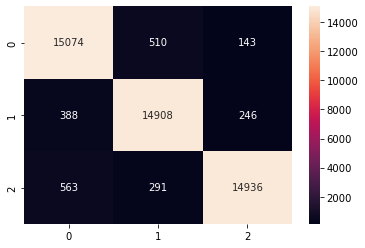

In [162]:
print("Negativo - 0     Neutro - 1      Positivo - 2")
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1),np.argmax(y_pred, axis=-1)), annot=True, fmt="d");

In [163]:
matrix = confusion_matrix(np.argmax(y_test, axis=-1),np.argmax(y_pred, axis=-1))
print("Negativo     Neutro     Positivo")
print(matrix.diagonal()/matrix.sum(axis=1))

Negativo     Neutro     Positivo
[0.95847905 0.95920731 0.94591514]
